In [1]:
# José Ávalos
# 19.492.037-7



import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Datos

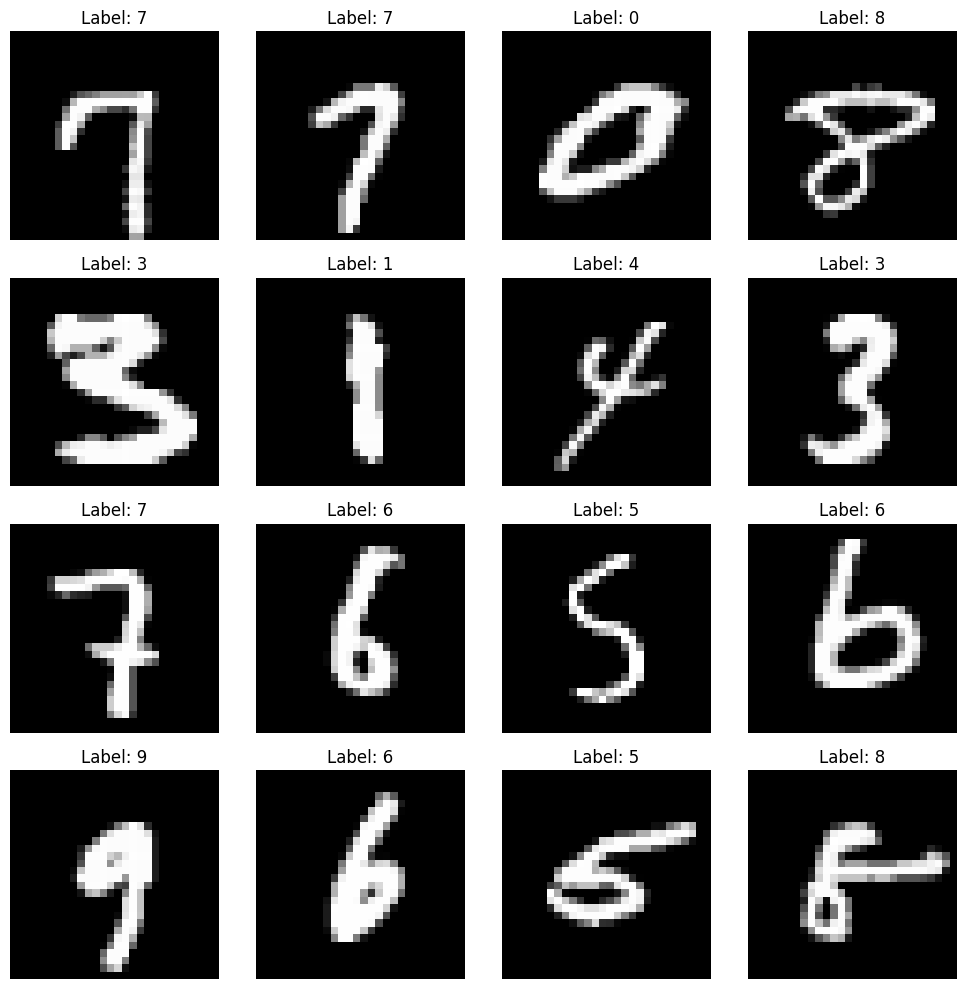

In [2]:

# Load MNIST dataset
# Definimos una secuencia de transformaciones para aplicar a las imágenes del dataset.
# En este caso, solo convertimos las imágenes a tensores utilizando `ToTensor()`.
# Esto es necesario para que las imágenes estén en un formato compatible con PyTorch.
transform = transforms.Compose([
    transforms.ToTensor()  # Convierte la imagen de un formato PIL o numpy.ndarray a un tensor.
])

# Cargamos el dataset MNIST de entrenamiento.
# `root='./data'` especifica el directorio donde se descargarán los datos si no están presentes.
# `train=True` indica que queremos el conjunto de datos de entrenamiento.
# `transform=transform` aplica las transformaciones definidas previamente a cada imagen.
# `download=True` descarga los datos si no están disponibles en el directorio especificado.
mnist_dataset = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)

# Creamos un DataLoader que nos permite cargar los datos en lotes pequeños.
# `dataset=mnist_dataset` es el dataset que se cargará.
# `batch_size=16` indica que cada lote contendrá 16 imágenes y etiquetas.
# `shuffle=True` mezcla los datos aleatoriamente en cada época, mejorando la generalización del modelo.
data_loader = DataLoader(
    mnist_dataset, batch_size=16, shuffle=True
)

# Obtenemos un único lote de datos del DataLoader.
# `next(iter(data_loader))` convierte el DataLoader en un iterador y toma el primer lote.
# El lote contiene `images` (los tensores de las imágenes) y `labels` (las etiquetas correspondientes).
images, labels = next(iter(data_loader))


# Plot the images in a grid
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Arquitectura

En relación a la arquitectura, se modificaron la cantidad de neuronas de las capas ocultas, esto ya que el incrementarlas permite capturar caracteristicas más complejas de los datos lo cual mejora el rendimiento para posibles problemas mas complicados.
Además, se añadió una nueva capa self.fc4, para permitir una mayor profundidas en la red neuronal, esto por puede permitir detectar caracteristicas más complejas.
También se cambió la función de activación, pasando de ReLU a LeakyReLU, ya que usar distintas funciones de activacion puede manejar mejor los tipos de datos y en este caso LeakyReLU evita que las neuronas se apaguen por completo.
Se ajustó el dropout incrementandolo al 30%, mejorando así la generalización en modelos más complejos.
Y por ultimo, se añadió un Batch Normalization, después de que las capas estén totalmente conectadas, acelerando el entrenamiento y mejorando su estabilidad.


In [3]:

# Definimos el modelo MLP
# MLP hereda de nn.Module, lo que permite utilizar las funciones y propiedades de PyTorch
# para crear, entrenar y evaluar redes neuronales.
class MLP(nn.Module):
    def __init__(self):
        # Inicializamos la clase base nn.Module
        # Esto habilita funciones esenciales como la gestión de capas y forward pass.
        super(MLP, self).__init__()
        # Capa completamente conectada: de entrada (28x28 píxeles) a 512 neuronas
        self.fc1 = nn.Linear(28 * 28, 512)
        # Capa oculta: de 512 neuronas a 256 neuronas
        self.fc2 = nn.Linear(512, 256)
        # Capa de salida: de 256 neuronas a 10 clases (números del 0 al 9)
        self.fc3 = nn.Linear(256, 128)
        
        self.fc4 = nn.Linear(128, 10)

        # Función de activación ReLU
        self.activation = nn.LeakyReLU()
        # Dropout para evitar sobreajuste
        self.dropout = nn.Dropout(0.3)

    # Definimos cómo pasa la información a través de la red
    # Este método es obligatorio en las clases que heredan de nn.Module.
    def forward(self, x):
        x = x.view(x.size(0), -1)
        #x = x.view(-1, 28 * 28)  # Aplanamos las imágenes (de 28x28 a 1D)
        x = self.activation(self.fc1(x))  # Aplicamos la primera capa y ReLU
        x = self.dropout(x)         # Aplicamos Dropout
        x = self.activation(self.fc2(x))  # Aplicamos la segunda capa y ReLU
        x = self.dropout(x)         # Aplicamos Dropout
        x = self.activation(self.fc3(x))  # Aplicamos la tercera capa y ReLU
        x = self.dropout(x)         # Aplicamos Dropout
        x = self.fc4(x)             # Aplicamos la capa de salida        
        return x

# Entrenamiento

Para la etapa de entrenamiento, se modificaron los hiperparámetros:
En el batch_size se cambió de 64 a 128, ya que con lotes mas grandes se puede mejorar la precisión en las tareas mientras se mantiene un entrenamiento más eficiente.
Se modificó el epochs a 20, el cual permite que el modelo pueda aprender más patrones de los datos.
Se modificó el learning_rate a 0.01, permitiendo que esta tasa de aprendizaje más alta pueda acelerar el aprendizaje para las primeras etapas.

Por ultimo, para el algoritmo de optimización, se sustituyó por el optimizador SGD, ya que de los vistos, el SGD puede superar su desempeño con un momentum incluido, permitiendo tener un mejor control sobre el sobreajuste.

In [4]:
# Hiperparámetros
batch_size = 128       # Tamaño de lote
learning_rate = 0.01 # Tasa de aprendizaje
epochs = 20           # Número de épocas de entrenamiento

# Preprocesamiento y carga de datos de MNIST
transform = transforms.Compose([
    transforms.ToTensor(),                 # Convertimos imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizamos a media 0 y varianza 1
])
train_dataset = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)  # Dataset de entrenamiento

test_dataset = datasets.MNIST(
    root='./data', train=False, transform=transform, download=True)  # Dataset de prueba

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True)  # Dataloader para entrenamiento

test_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False)  # Dataloader para prueba

# Definimos el modelo, la función de pérdida y el optimizador
model = MLP()                             # Creamos una instancia del modelo MLP
criterion = nn.CrossEntropyLoss()         # Función de pérdida para clasificación

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Optimizador Adam

#Programador de tasas de aprendizaje para reducir el learning_rate durante el entrenamienoto.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


# Bucle de entrenamiento
for epoch in range(epochs):
    model.train()  # Ponemos el modelo en modo entrenamiento
    running_loss = 0.0
    for images, labels in train_loader:  # Iteramos sobre lotes de datos
        optimizer.zero_grad()            # Reiniciamos los gradientes
        outputs = model(images)          # Hacemos una predicción con el modelo
        loss = criterion(outputs, labels)  # Calculamos la pérdida
        loss.backward()                  # Propagamos los gradientes
        optimizer.step()                 # Actualizamos los pesos del modelo
        running_loss += loss.item()     # Acumulamos la pérdida

    scheduler.step()
    print(f"Época [{epoch+1}/{epochs}], Pérdida Promedio: {running_loss / len(train_loader):.4f}")



Época [1/20], Pérdida Promedio: 0.8143
Época [2/20], Pérdida Promedio: 0.2865
Época [3/20], Pérdida Promedio: 0.2135
Época [4/20], Pérdida Promedio: 0.1762
Época [5/20], Pérdida Promedio: 0.1505
Época [6/20], Pérdida Promedio: 0.1200
Época [7/20], Pérdida Promedio: 0.1089
Época [8/20], Pérdida Promedio: 0.1024
Época [9/20], Pérdida Promedio: 0.0972
Época [10/20], Pérdida Promedio: 0.0882
Época [11/20], Pérdida Promedio: 0.0791
Época [12/20], Pérdida Promedio: 0.0745
Época [13/20], Pérdida Promedio: 0.0710
Época [14/20], Pérdida Promedio: 0.0690
Época [15/20], Pérdida Promedio: 0.0685
Época [16/20], Pérdida Promedio: 0.0628
Época [17/20], Pérdida Promedio: 0.0598
Época [18/20], Pérdida Promedio: 0.0591
Época [19/20], Pérdida Promedio: 0.0581
Época [20/20], Pérdida Promedio: 0.0583


# Evaluación del modelo

In [5]:
model.eval()  # Ponemos el modelo en modo evaluación (desactiva Dropout)
correct = 0
total = 0
with torch.no_grad():  # Desactivamos el cálculo de gradientes para evaluación
    for images, labels in test_loader:  # Iteramos sobre los datos de prueba
        outputs = model(images)         # Hacemos predicciones
        _, predicted = torch.max(outputs.data, 1)  # Obtenemos la clase con mayor probabilidad
        total += labels.size(0)         # Total de muestras evaluadas
        correct += (predicted == labels).sum().item()  # Contamos las predicciones correctas

# Calculamos y mostramos la precisión del modelo
accuracy = 100 * correct / total
print(f"Accuracy en el conjunto de prueba: {accuracy:.2f}%")

Accuracy en el conjunto de prueba: 98.10%


In [6]:
# Verificar si hay una GPU disponible, de lo contrario usar la CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocesamiento: Definir transformaciones para los datos
transform = transforms.Compose([
    transforms.ToTensor(),                # Convertir imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizar los valores a un rango de [-1, 1]
])

# Cargar el conjunto de datos MNIST
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)  # Datos de entrenamiento
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)  # Datos de prueba

# Crear DataLoaders para manejar los datos de forma eficiente
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)   # Loader para entrenamiento (batch de 128, mezclado)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)    # Loader para prueba (batch de 128, sin mezclar)

class CNN(nn.Module):
    def __init__(self, verbose=False, filters_l1=32, filters_l2=64, dropout=0.2, final_layer_size=128):
        super(CNN, self).__init__()
        self.verbose = verbose
        self.filters_l1 = filters_l1
        self.filters_l2 = filters_l2
        self.dropout_rate = dropout
        self.final_layer_size = final_layer_size

        # Primera capa convolucional
        self.conv1 = nn.Conv2d(1, self.filters_l1, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Segunda capa convolucional
        self.conv2 = nn.Conv2d(self.filters_l1, self.filters_l2, kernel_size=3, stride=1, padding=1)

        # Calcular automáticamente las dimensiones de la capa lineal (fc1)
        self.fc1_input_size = self._calculate_fc1_input_size()
        
        # Primera capa completamente conectada
        self.fc1 = nn.Linear(self.fc1_input_size, self.final_layer_size)
        self.dropout = nn.Dropout(self.dropout_rate)
        self.fc2 = nn.Linear(self.final_layer_size, 10)  # Capa de salida para 10 clases (MNIST)

    def _calculate_fc1_input_size(self):
        """
        Calcula automáticamente el tamaño de la entrada para la primera capa completamente conectada (fc1).
        Simula una pasada con una imagen de prueba de tamaño (1, 28, 28).
        """
        with torch.no_grad():  # Desactiva gradientes
            x = torch.randn(1, 1, 28, 28)  # Tensor ficticio de entrada con tamaño MNIST (batch_size=1)
            x = self.pool(torch.relu(self.conv1(x)))  # Aplicar Conv1 -> Pool
            x = self.pool(torch.relu(self.conv2(x)))  # Aplicar Conv2 -> Pool
            fc1_input_size = x.numel()  # Calcular número total de elementos
        return fc1_input_size

    def forward(self, x):
        if self.verbose: 
            print(f"Entrada: {x.shape}")  # Imprime la dimensión de la entrada

        # Primera capa convolucional, ReLU y MaxPooling
        x = self.pool(torch.relu(self.conv1(x)))
        if self.verbose:
            print(f"Después de Conv1 y MaxPooling: {x.shape}")  # Dimensión después de Conv1 y Pool

        # Segunda capa convolucional, ReLU y MaxPooling
        x = self.pool(torch.relu(self.conv2(x)))
        if self.verbose:
            print(f"Después de Conv2 y MaxPooling: {x.shape}")  # Dimensión después de Conv2 y Pool

        # Aplanar las características 2D a 1D
        x = x.view(-1, self.fc1_input_size)
        if self.verbose:
            print(f"Después de Aplanamiento: {x.shape}")  # Dimensión después de Flatten

        # Primera capa completamente conectada
        x = torch.relu(self.fc1(x))
        if self.verbose:
            print(f"Después de Fully Connected (fc1): {x.shape}")  # Dimensión después de fc1

        # Aplicar Dropout
        x = self.dropout(x)
        if self.verbose:
            print(f"Después de Dropout: {x.shape}")  # Dimensión después de Dropout

        # Capa de salida
        x = self.fc2(x)
        if self.verbose:
            print(f"Después de Fully Connected (fc2): {x.shape}")  # Dimensión después de fc2 (salida final)

        return x



In [7]:
# Inicializar el modelo, la función de pérdida y el optimizador
model = CNN(verbose=False, filters_l1=8, filters_l2=32, dropout=0.2, final_layer_size=128).to(device)                             # Mover el modelo a la GPU/CPU
criterion = nn.CrossEntropyLoss()                    # Función de pérdida para clasificación multiclase
optimizer = optim.Adam(model.parameters(), lr=0.001) # Optimizador Adam con tasa de aprendizaje 0.001

# Definir la función de entrenamiento
def train(model, loader, criterion, optimizer, device):
    model.train()  # Establecer el modelo en modo de entrenamiento
    running_loss = 0.0
    for images, labels in loader:  # Iterar sobre los lotes de datos
        images, labels = images.to(device), labels.to(device)  # Mover los datos a la GPU/CPU

        optimizer.zero_grad()       # Reiniciar los gradientes
        outputs = model(images)     # Paso hacia adelante
        loss = criterion(outputs, labels)  # Calcular la pérdida
        loss.backward()             # Paso hacia atrás (cálculo de gradientes)
        optimizer.step()            # Actualizar los pesos

        running_loss += loss.item()  # Acumular la pérdida
    return running_loss / len(loader)  # Devolver la pérdida promedio

# Definir la función de evaluación
def evaluate(model, loader, device):
    model.eval()  # Establecer el modelo en modo de evaluación
    correct = 0
    total = 0
    with torch.no_grad():  # Deshabilitar el cálculo de gradientes para ahorrar memoria
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)  # Mover datos a la GPU/CPU
            outputs = model(images)  # Paso hacia adelante
            _, predicted = torch.max(outputs, 1)  # Obtener las predicciones (clase con mayor probabilidad)
            total += labels.size(0)  # Contar el número total de ejemplos
            correct += (predicted == labels).sum().item()  # Contar las predicciones correctas
    return correct / total  # Calcular la precisión

# Bucle principal de entrenamiento
num_epochs = 10  # Número de épocas
for epoch in range(num_epochs):
    # Entrenar el modelo y calcular la pérdida
    train_loss = train(model, train_loader, criterion, optimizer, device)
    # Evaluar el modelo en el conjunto de prueba
    test_accuracy = evaluate(model, test_loader, device)
    # Imprimir los resultados de la época actual
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Calcular la precisión final en el conjunto de prueba
final_accuracy = evaluate(model, test_loader, device)
print(f"Final Test Accuracy: {final_accuracy:.4f}")


Epoch [1/10], Loss: 0.3016, Test Accuracy: 0.9772
Epoch [2/10], Loss: 0.0808, Test Accuracy: 0.9850
Epoch [3/10], Loss: 0.0596, Test Accuracy: 0.9882
Epoch [4/10], Loss: 0.0472, Test Accuracy: 0.9879
Epoch [5/10], Loss: 0.0406, Test Accuracy: 0.9904
Epoch [6/10], Loss: 0.0332, Test Accuracy: 0.9888
Epoch [7/10], Loss: 0.0280, Test Accuracy: 0.9919
Epoch [8/10], Loss: 0.0273, Test Accuracy: 0.9900
Epoch [9/10], Loss: 0.0242, Test Accuracy: 0.9901
Epoch [10/10], Loss: 0.0210, Test Accuracy: 0.9911
Final Test Accuracy: 0.9911
